In [1]:
import os
import numpy as np
import tensorflow as tf # tensorboard --logdir ./models
import matplotlib.pyplot as plt

random_seed = 42 # Fixing the seed for PRNGs, to help reproducibility
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [2]:
from cityscapes_utils import (
    CITYSCAPES_FOLDER, # change this variable to Cityscapes root folder
    CITYSCAPES_LABELS, CITYSCAPES_IGNORE_VALUE, 
    cityscapes_input_fn, get_cityscapes_file_pairs,
    postprocess_to_show, change_ratio)

from utils.plot_utils import plot_image_grid

In [3]:
batch_size     = 8
num_epochs     = 90
image_size     = [512, 512]
num_channels   = 3
num_classes    = len(CITYSCAPES_LABELS)
random_seed    = 1
num_show       = 3

In [4]:
num_train_imgs = len(get_cityscapes_file_pairs(split='train', 
                                               root_folder=CITYSCAPES_FOLDER)[0])
num_val_imgs   = len(get_cityscapes_file_pairs(split='val', 
                                               root_folder=CITYSCAPES_FOLDER)[0])

train_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)
val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=1, augment=False, seed=random_seed)

# For visualization purpose, we also create a validation dataset using the images 
# with blurred faces/immatriculation plates (for privacy). As we will just use 
# 2-3 images, we only create the `tf.data.Dataset` to grab one batch:
visual_val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=num_show,
    shuffle=True, num_epochs=1, augment=False, seed=random_seed, blurred=True)

val_image_samples, val_gt_samples = next(visual_val_dataset.__iter__())
del visual_val_dataset

In [5]:
import math

# Number of batches per train/val epoch, to guide the Keras `fit` method:
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

In [6]:
from unet import unet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Network hyper-parameters:
kernel_size    = 4
filters_orig   = 32
layer_depth    = 4
use_batch_norm = batch_size > 1

In [7]:
inputs = Input(shape=(*image_size, num_channels), name='input')
outputs = unet(inputs, out_channels=num_classes, 
               layer_depth=layer_depth, filters_orig=filters_orig, 
               kernel_size=kernel_size, batch_norm=use_batch_norm,
               final_activation=None # we define our U-Net to output logits.
              )

unet_model = Model(inputs, outputs)

In [8]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
enc_conv0-1 (Conv2D)            (None, 512, 512, 32) 1568        input[0][0]                      
__________________________________________________________________________________________________
enc_bn0-1 (BatchNormalization)  (None, 512, 512, 32) 128         enc_conv0-1[0][0]                
__________________________________________________________________________________________________
enc_act0-1 (LeakyReLU)          (None, 512, 512, 32) 0           enc_bn0-1[0][0]                  
______________________________________________________________________________________________

In [12]:
from tf_losses_and_metrics import (
    SegmentationLoss, SegmentationAccuracy, SegmentationMeanIoU, 
    get_mask_for_valid_labels)

In [13]:
from utils.plot_utils import plot_image_grid

def predict_and_postprocess(images, gt_labels):
    """
    Use the model to predict the label map, and post-process the data for visualization.
    :param images:      Images
    :param gt_labels:   Ground-truth label maps
    :return:            Images, predicted label maps and GT label maps ready for display
    """

    predicted_onehot = unet_model(images)

    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted = tf.math.argmax(predicted_onehot, axis=-1)
    predicted = tf.expand_dims(predicted, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        images, predicted, gt_labels, one_hot=True)
    
    return images_show, predicted_show, gt_show

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


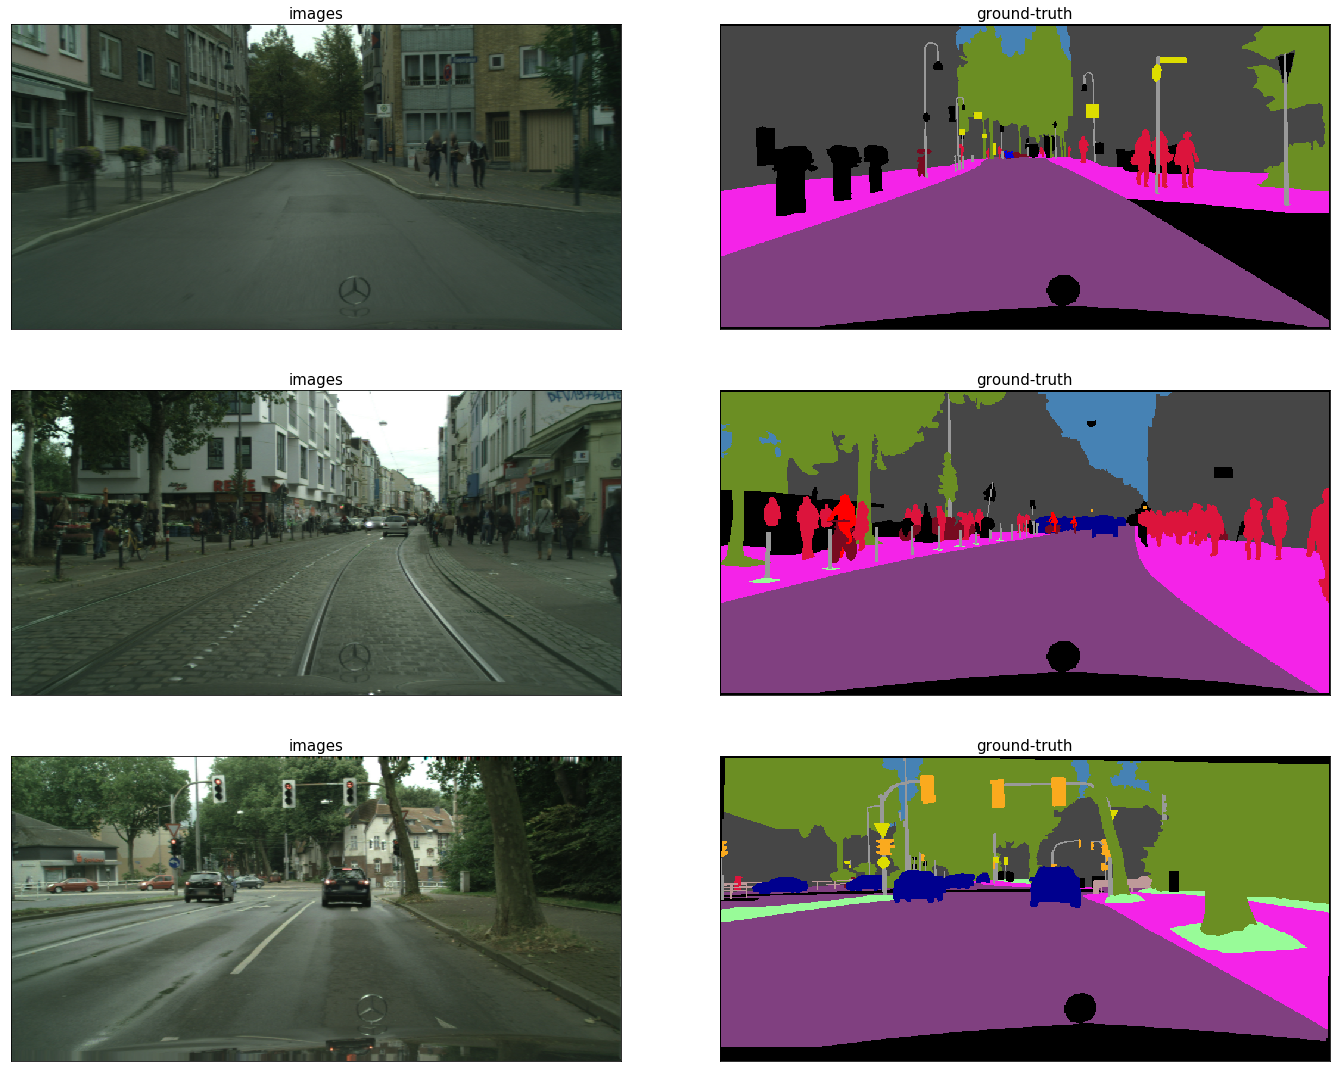

In [14]:
# Simply visualizing the input/target pairs for now:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), gt_show.numpy()], 
                         titles=["images", "ground-truth"])
figure.show()

In [16]:
from utils.keras_custom_callbacks import TensorBoardImageGridCallback

model_name = 'cityscapes_unet'
model_dir = os.path.join('models', model_name)

def postprocess_for_grid_callback(input_images, predicted_images, gt_images):
    
    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted_images = tf.math.argmax(predicted_images, axis=-1)
    predicted_images = tf.expand_dims(predicted_images, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        input_images, predicted_images, gt_images, one_hot=True)

    return images_show, predicted_show, gt_show

# Callback to postprocess some validation results and display them in Tensorboard:
callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, 
    input_images=val_image_samples, target_images=val_gt_samples, 
    preprocess_fn=postprocess_for_grid_callback,
    tag=model_name + '_results', figsize=(15, 15))

<Figure size 4500x4500 with 0 Axes>

In [17]:
import collections
from utils.keras_custom_callbacks import SimpleLogCallback

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                            ("acc", "acc"), ("v-acc", "val_acc"),
                                            ("mIoU", "mIoU"), ("v-mIoU", "val_mIoU")])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

In [26]:
optimizer = tf.keras.optimizers.Adam()

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), save_freq=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    callback_tb_grid
]

unet_model.compile(optimizer=optimizer, loss=SegmentationLoss(from_logits=True), 
                    metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])

history = unet_model.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=1, callbacks=callbacks)

Train for 372 steps, validate for 63 steps
Training: start.
Epoch 1/90
  1/372 [..............................] - ETA: 1:27:15WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 
Training: end.


KeyError: 'loss'